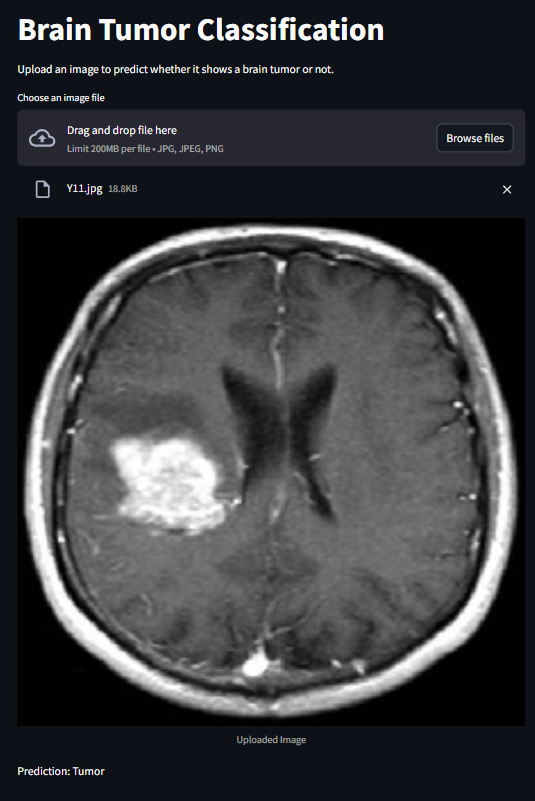

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os
import matplotlib.pyplot as plt
import streamlit as st
from tensorflow.keras.preprocessing import image
import numpy as np

In [5]:
# Charger les poids pré-entranés de VGG16 sans les couches supérieures
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Rendre les couches du VGG non entraînables
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches personnalisées pour la classification binaire
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Classification binaire
])

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Configuration des générateurs d'images pour la préparation des données
data_dir = "brain_tumor_dataset"  # Le chemin de vos données
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

In [6]:
data_gen = ImageDataGenerator(rescale=1./255, 
                               rotation_range=20, 
                               width_shift_range=0.2, 
                               height_shift_range=0.2, 
                               shear_range=0.2, 
                               zoom_range=0.2, 
                               horizontal_flip=True, 
                               fill_mode='nearest')

train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 215 images belonging to 2 classes.
Found 38 images belonging to 2 classes.


In [ ]:
# Entraînement du modèle

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping]
)


print("Train successfully completed !")


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 57s 8s/step - accuracy: 0.8241 - loss: 0.4303 - val_accuracy: 0.9211 - val_loss: 0.2800
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 53s 8s/step - accuracy: 0.8325 - loss: 0.4114 - val_accuracy: 0.8947 - val_loss: 0.4053
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - accuracy: 0.8082 - loss: 0.4271 - val_accuracy: 0.8947 - val_loss: 0.4062
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 66s 8s/step - accuracy: 0.8310 - loss: 0.3922 - val_accuracy: 0.9211 - val_loss: 0.3444
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 51s 7s/step - accuracy: 0.8127 - loss: 0.4140 - val_accuracy: 0.8684 - val_loss: 0.2809
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 9s/step - accuracy: 0.7932 - loss: 0.4359 - val_accuracy: 0.8421 - val_loss: 0.3500
Train successfully completed !


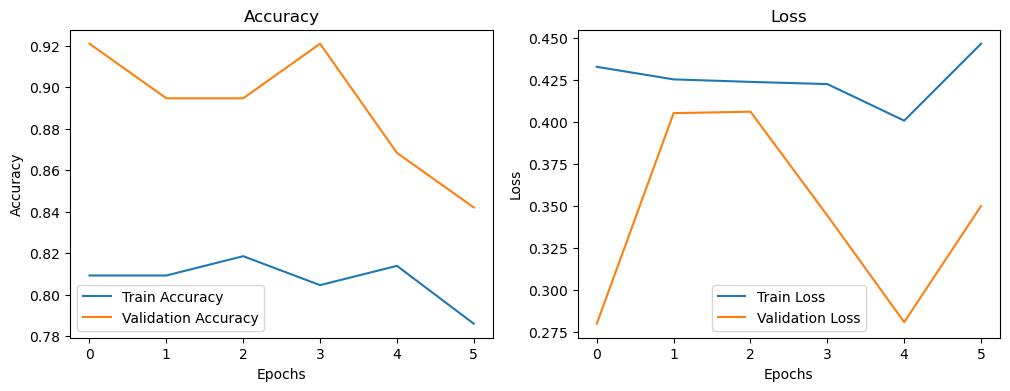

In [15]:
import matplotlib.pyplot as plt
# Visualiser les performances du modèle
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot de l'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot de la loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

In [8]:
import os

# Vérifiez si le fichier existe avant de sauvegarder
model_path = "brain_tumor_vgg_model.keras"  # Nouveau format recommandé
if os.path.exists(model_path):
    os.remove(model_path)  # Supprime le fichier existant

# Sauvegarder le modèle dans le format natif Keras
model.save(model_path)
print(f"Model saved successfully at {model_path}")


Model saved successfully at brain_tumor_vgg_model.keras


In [10]:
# Exemple de prédiction sur une image
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return "Tumor" if prediction[0][0] > 0.5 else "No Tumor"

# Exemple : remplacer "path_to_image" par le chemin d'une image
result = predict_image(model, "no/predictno.jpeg")
print(f"Prediction: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: No Tumor
